# Introduction
This document conducts experiments to observe features of barrier function and perturbed optimizer methods. We create a toy Linear Program (LP) example, and apply both methods to approximate this LP. Experiment results reveal the features of each method. Section 1 demonstrates the toy LP example, covers its feasible region and solutions. Section 2 and 3 approximates this LP with barrier function and perturbed optimizer methods, respectively.

In [ ]:
import numpy as np

In [ ]:
# import tensorflow.compat.v2 as tf
import tensorflow as tf
from scipy.optimize import linprog
import functools
from typing import Tuple
import numpy as np
import cvxpy as cp
import scipy.optimize as opt
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
# %matplotlib notebook
%matplotlib inline
import bisect
import time
import math

# Section 1: Basic examples for Perturbed Optimiser Method and Barrier Function Method

Consider the linear program
\begin{align}
 	\begin{array}{rll}
\text{minimize}& \theta x_1-4x_2 \\
 \text{subject to} 
 &x_1+x_2 \leq 30 \\
 & x_2 \geq 0,  x_1 \geq 1\\
\end{array}
 \end{align}

 The feasible region is shown as follows, which is a triangle. A property of linear program is that the optimal solution always lie on one of its feasible region vertices. When we change the input $\theta$, the resulted optimal solution $x^\star$ jumps between vertices. The output is now a piece-wise constant function of input $\theta$, and its gradient is a constant zero function with discontinuities spread inbetween. 


In [1]:
d = np.linspace(-2,70,300)
'''
Plot feasible region for sample linear programming problem 1.
'''
d = np.linspace(-2,70,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((x>=1) & (y>=0) & (x+y<=30)).astype(int) , 
               extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);


# plot the lines defining the constraints
x = np.linspace(-2, 70, 2000)
y1 = (x*0) + 0
y3 = 30 - x

plt.axvline(x=1, label = r'$x_1 = 1$')
plt.plot(x, 0*np.ones_like(y1), label = r'$x_2 = 0$')
plt.plot(x, y3, label=r'$x_1 + x_2 = 30$')
plt.xlim(0,35)
plt.ylim(0,35)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.title('Feasibile region of sample optimisation problem')
plt.show()


NameError: name 'np' is not defined

This problem can be solved through SciPy linprog. Scipy linprog still uses interior point method, but the barriered optimsiation problem has feasible region extremely close to the original feasible region. The "exact" solution is plotted as follow.

Text(0.5, 1.0, 'Solution of sample problem 1 against x')

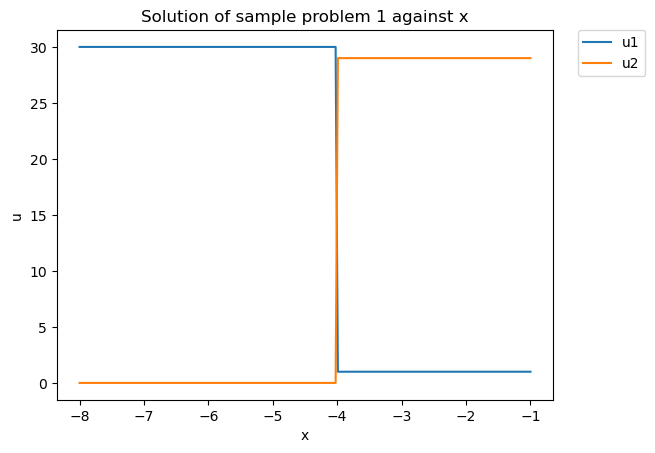

In [7]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
c = [-1.,-4.]
A = [[1.,1.]]
x0_bounds = (1, None)
x1_bounds = (0, None)
x_data = -1* np.linspace(1,8,200)
u_data1_real = []
u_data2_real = []
for c[0] in x_data:
    b = [[30]]
    res = linprog(c, A_ub=A, b_ub=b,A_eq= None, b_eq= None,bounds=[x0_bounds,x1_bounds])
    try:
        u_data1_real.append(res.x[0])      
        u_data2_real.append(res.x[1])
    except:
        print(x)
        break
    
#Plot solution
plt.plot(x_data,u_data1_real,label = 'u1')
plt.plot(x_data,u_data2_real, label = 'u2')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Solution of sample problem 1 against x')

## Barrier Funtion (Interior point) Method

By combining the constraints of the sample liear programming problem, we obtain a new unconstrained linear programming problem with objective function as follows

\begin{align}
 	\begin{array}{rll}
\text{minimize}& t(-xu_1-4u_2) - \text{log} (30-u_1-u_2) - \text{log}(u_2) - \text{log}(u_1-1)\\
\end{array}
 \end{align}


The constraints of the original optimisation problem are negated and put into the log function. Since the domain of the log function is in the postive reals, the negated constraints has to be positive to ensure the barriered optimisation function is well defined, and this enforces the feasible region of the unconstrained (barriered) optimisation problem matches with constraints of the original problem.

What's more, lim log($0^+$) $\rightarrow$ $-\infty$, so the log term will approaches to positve infinity when the solution reaches to the boundary of the feasible region. With the sign of the log term being negative, the terms -log(*) will diverge to $\infty$ and hence gives a penalty to the minimisation problem. The barrier coefficient $t$ is introduced to increase the weight of the original objective function and balance out this penalty.

Nonetheless, the solution of barriered optimisation problem can never precisely match with the original optimisation problem. A fact of linear programming problem is that all of its solutions lie on the vertices of it polytope feasible region. By the strict positivity of the log domain, the feasible region of the barrired optimisation problem is always contained in the feasible region of the original barrier functions differed from the boundaries (hence vertices). The ground truth solutions of the original LP are not even contained in the barriered function, so the best that barrierr function method can do is to approximate the solution that converges to the ground truth solution.




The average time cost for determining one barriered solution is 0.014089 seconds


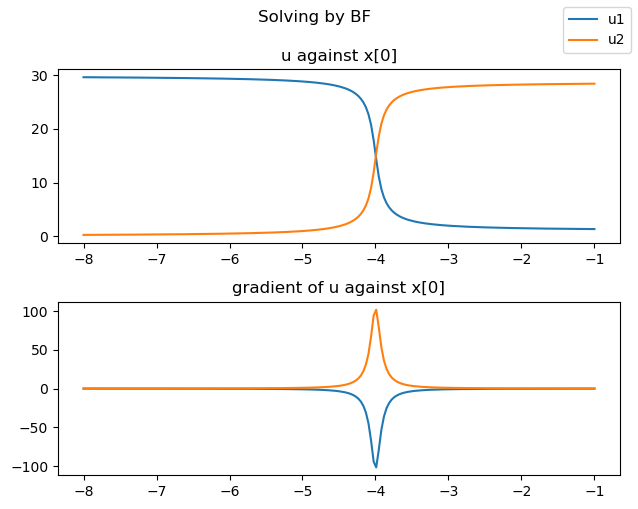

In [8]:
#Objective function and its partial derivatives
def objective(t,x,u):
    return t*x@u-np.log(u[0]-1)-np.log(30.-u[1]-u[0])-np.log(u[1])
def objective_dy(t,x,u):
    return np.array([t*x[0]-1/(u[0]-1)+1/(30-u[0]-u[1]),-t*x[1]-1/(u[1])+1/(30-u[0]-u[1])])
def objective_dxy(t,x,u):
     return np.matrix([[t,0],\
                      [0,t]])
def objective_dyy(x,u):
    return np.matrix([[np.power(u[0]-1,-2)+np.power(30-u[0]-u[1],-2),np.power(30-u[0]-u[1],-2)],\
                      [np.power(30-u[0]-u[1],-2),np.power(30-u[0]-u[1],-2)+1/np.power(u[1],2)]])
def objective_gradient(t,x,u):
    return -np.linalg.inv(objective_dyy(x,u))*objective_dxy(t,x,u)


u = cp.Variable(2)
#Initialise input x
x = np.array([3.,-4.])
x_data = -1*np.linspace(1,8,200)
#Barrier coefficient t
t = 1
#Storage vector for u_1, u_2 and their gradients w.r.t x_1
time_cost = []
u_data0 = []
u_data1 = []
gradient0 = []
gradient1 = []
fig, axs = plt.subplots(2)
ttl = fig.suptitle('Solving by BF')
ttl.set_position([.5, 1.05])
for x[0] in x_data:
    #Objective function of barriered problem
    objec = lambda u: cp.Minimize(t*x@u-cp.log(u[0]-1)-cp.log(30.-u[1]-u[0])-cp.log(u[1]))
    #Solving the problem with CVXPY
    prob = cp.Problem(objec(u))
    start = time.time()
    prob.solve()
    end = time.time()
    time_cost.append(end-start)
    u_data0.append(u.value[0])
    u_data1.append(u.value[1])
    #Determine the gradient of the solution with the derived equation
    gradient = objective_gradient(t,x,u.value)
    gradient0.append(gradient[0,0])
    gradient1.append(gradient[1,0])
axs[0].plot(x_data,u_data0,label = 'u1')
axs[0].plot(x_data,u_data1,label = 'u2')
axs[1].plot(x_data,gradient0)
axs[1].plot(x_data,gradient1)
axs[0].set_title('u against x[0]')
axs[1].set_title('gradient of u against x[0]')
fig.tight_layout()
fig.legend()
print("The average time cost for determining one barriered solution is %f seconds" %np.mean(time_cost))

## Perturbed Optimiser Method

Perturbed optimiser method perturbes the input data and obtain the expected value of perturbed output. Perturbations are conducted by adding noises to input data, the noises are under standard Gumbel or Normal distribution for the ease of back propagation. In particular, noises $\epsilon Z$ should have distributions $\mu(z) \propto \exp(-\nu(z)) dz$, where the gradient of perturbed output against input is determined by  $$
\mathbb{E}[y^*(\theta + \epsilon Z)\nabla_z \nu(Z)^T/\epsilon]
$$
$\theta + \epsilon Z$ is the perturbed input, $\epsilon$ is the temperature coefficient of noise and $\nabla_z \nu(Z)$ is the derivation of $\nu$ function embraced by exponential function.

Standard Normal distribution has pdf $\frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}x^2\,\right)$. $\nabla_x\nu(x) = x$
  
Standard Gumbel distribution has pdf $\exp(-(x+\exp(-x)))$. $\nabla_x\nu(x) = 1-\exp(-x)$
  
  
Perturbation is conducted using tensorflow package with the code provided by the paper **Learning with Differentiable Perturbed Optimizers**. However, in testing sample provided below, we only care about the partial derivative of outputs agagints particular compoenents of inputs. The codes are modified to return partial derivatives instead of overall derivative.

### Perturbation Code (Modified from **Learning with Differentiable Perturbed Optimizers**)

In [9]:
_GUMBEL = 'gumbel'
_NORMAL = 'normal'
SUPPORTED_NOISES = (_GUMBEL, _NORMAL)


def sample_noise_with_gradients(
    noise, shape):
  if noise not in SUPPORTED_NOISES:
    raise ValueError('{} noise is not supported. Use one of [{}]'.format(
        noise, SUPPORTED_NOISES))

  if noise == _GUMBEL:
    sampler = tfp.distributions.Gumbel(0.0, 1.0)
    samples = sampler.sample(shape)
    gradients = 1 - tf.math.exp(-samples)
  elif noise == _NORMAL:
    sampler = tfp.distributions.Normal(0.0, 1.0)
    samples = sampler.sample(shape)
    gradients = samples

  return samples, gradients


def perturbed(func=None,
              num_samples = 1000,
              sigma = 0.05,
              noise = _NORMAL,
              batched = True):
  if func is None:
    return functools.partial(
        perturbed, num_samples=num_samples, sigma=sigma, noise=noise,
        batched=batched)

  @functools.wraps(func)
  def wrapper(input_tensor, *args, **kwargs):
    @tf.custom_gradient
    def forward(input_tensor, *args, **kwargs):
      """The differentiation by perturbation core routine."""
      original_input_shape = tf.shape(input_tensor)
      if batched:
        tf.debugging.assert_rank_at_least(
            input_tensor, 2, 'Batched inputs must have at least rank two')
      else:  # Adds dummy batch dimension internally.
        input_tensor = tf.expand_dims(input_tensor, 0)
      input_shape = tf.shape(input_tensor)  # [B, D1, ... Dk], k >= 1, Dimension of the tensor, in a sigle number.
      perturbed_input_shape = tf.concat([[num_samples], input_shape], axis=0) #The storage space size for all perturbed sequence.

      noises = sample_noise_with_gradients(noise, perturbed_input_shape) #Create noises
      additive_noise, noise_gradient = tuple(
          [tf.cast(noise, dtype=input_tensor.dtype) for noise in noises]) #Cast the noise to make the noise and input tensor operable
      perturbed_input = tf.expand_dims(input_tensor, 0) + sigma * additive_noise #Add noises to the input tensor, if the expansion in dimension necessary tho?

      # [N, B, D1, ..., Dk] -> [NB, D1, ..., Dk].
      flat_batch_dim_shape = tf.concat([[-1], input_shape[1:]], axis=0)
      perturbed_input = tf.reshape(perturbed_input, flat_batch_dim_shape)
      # Calls user-defined function in a perturbation agnostic manner.
      perturbed_output = func(perturbed_input, *args, **kwargs)
      # [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk].
      perturbed_input = tf.reshape(perturbed_input, perturbed_input_shape)
      # Either
      #   (Default case): [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk]
      # or
      #   (Full-reduce case) [NB] -> [N, B]
      perturbed_output_shape = tf.concat(
          [[num_samples], [-1], tf.shape(perturbed_output)[1:]], axis=0)
    

      perturbed_output = tf.reshape(perturbed_output, perturbed_output_shape)

      forward_output = tf.reduce_mean(perturbed_output, axis=0)
      if not batched:  # Removes dummy batch dimension.
        forward_output = forward_output[0]

      def grad(dy):
        """Compute the gradient of the expectation via integration by parts."""
        output, noise_grad = perturbed_output, noise_gradient
        
        # Adds dummy feature/channel dimension internally.
        if perturbed_input.shape.rank > output.shape.rank:
          dy = tf.expand_dims(dy, axis=-1)
          output = tf.expand_dims(output, axis=-1)
        # Adds dummy batch dimension internally.
        if not batched:
          dy = tf.expand_dims(dy, axis=0)
        # Flattens [D1, ..., Dk] to a single feat dim [D].
        flatten = lambda t: tf.reshape(t, (tf.shape(t)[0], tf.shape(t)[1], -1))
        dy = tf.reshape(dy, (tf.shape(dy)[0], -1))  # (B, D)
        output = flatten(output)  # (N, B, D)
        noise_grad = flatten(noise_grad)  # (N, B, D)
        g = tf.einsum('nbi,nbj->nij', output, noise_grad)
        g = tf.math.reduce_mean(g,0)
        g /= sigma
        return g
      return forward_output, grad

    return forward(input_tensor, *args, **kwargs)

  return wrapper


In [12]:
'''
Preliminary functions for sample linear programming problem 1. 
'''
def Sample_LinProg1(x):
    x = x.numpy()
    solution = np.zeros([len(x),2])
    for i in range(x.shape[0]):
        u = cp.Variable(2)
        coe = [x[i],-4.]
        objec = lambda coe,u: cp.Minimize(coe@u)
        constraints = [u[0] >= 1,u[0]+u[1] <= 30, u>=0]
        prob = cp.Problem(objec(coe,u),constraints)
        prob.solve()
        solution[i,:] = u.value
    solution = tf.cast(solution,dtype='double')
    return solution

linprog1_pert = perturbed(Sample_LinProg1,num_samples=2000,
                                      sigma=0.05,
                                      noise='gumbel',
                                      batched=False)

The average time cost for determining one perturbed solution is 18.558503 seconds


/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


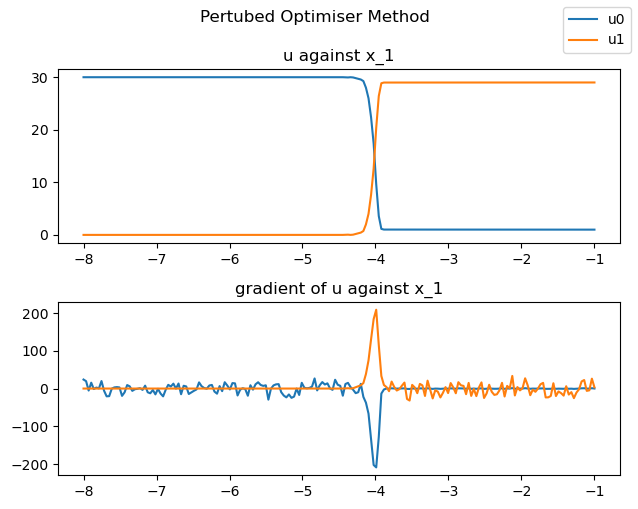

In [13]:
x = np.array([-3.,-4.])
x_data = -1*np.linspace(1,8,200)
solution = np.zeros([len(x_data),2])
solution_grad = np.zeros_like(solution)
time_cost = []
for i in range(len(x_data)):
    x = x_data[i]
    with tf.GradientTape() as tape:  
        x_var = tf.Variable(x)
        tape.watch(x_var)
        start = time.time()
        pert_output = linprog1_pert(x_var)
        end = time.time()
    grad = tape.gradient(pert_output,x_var)
    grad = tf.reshape(grad,(1,2))
    time_cost.append(end-start)
    solution[i,:] = pert_output
    solution_grad[i,:] = grad
fig,axs = plt.subplots(2)
axs[0].plot(x_data,solution[:,0],label = 'u0')
axs[0].plot(x_data,solution[:,1],label = 'u1')
axs[0].set_title("u against x_1")
axs[1].plot(x_data,solution_grad[:,0])
axs[1].plot(x_data,solution_grad[:,1])
axs[1].set_title("gradient of u against x_1")
ttl = fig.suptitle('Pertubed Optimiser Method')
ttl.set_position([.5, 1.05])
fig.legend()
fig.tight_layout()
print("The average time cost for determining one perturbed solution is %f seconds" %np.mean(time_cost))
fig.show()

Start with a searching direction of [1,0], then rotate in counter-clockwise for 2$\pi$. The resulted solution with the varying solution is plotted as follow. It can be seen that the solution is jumping through the vertices of the hexagon where all six vertices have been the solution of some searching direction.